In [5]:
import os
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import soundfile as sf
import IPython
from scipy.io.wavfile import read
import librosa.display

In [6]:
train = []
for i in os.listdir('clean_trainset_28spk_wav'):
  a, _ = sf.read("clean_trainset_28spk_wav/" + i)
  train.append(a)

In [7]:
size = 0
for i in range(len(train)):
  size += train[i].shape[0]

In [8]:
mean_size = size/len(train)
mean_size

140235.45203940547

In [9]:
def make_same(data):
  temp = []
  for i in data:
    if i.shape[0]>mean_size:
      i = i[:140300]
    else:
      while i.shape[0] < 140300:
        i = np.append(i,0)
    temp.append(i)
  return temp

In [ ]:
train = make_same(train)
train_data = train[:9000]
test_data = train[9000:]

In [ ]:
train_noise = []
for i in os.listdir('noisy_trainset_28spk_wav'):
  a, _ = sf.read("noisy_trainset_28spk_wav/" + i)
  train_noise.append(a)

In [66]:
train_noise = make_same(train_noise)
noisy_train_data = train_noise[:]
noisy_test_data = train_noise[:]

In [70]:
sf.write('noisy_train_0.wav', noisy_train_data[0], 16000)
noisy_train_data[0]

array([-0.01343989,  0.00192831,  0.00218584, ...,  0.0045963 ,
       -0.00155012, -0.00095967])

In [69]:
sf.write('train_0.wav', train_data[0], 16000)
train_data[0] 

array([-0.0078125,  0.       ,  0.       , ...,  0.       ,  0.       ,
        0.       ])

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [35]:
input = layers.Input(shape=(4900,1,))

# Encoder
x = layers.Conv1D(32, 3, activation="relu", padding="same")(input)
x = layers.MaxPooling1D(3,strides =  2,padding="same")(x)
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling1D(3,strides = 2, padding="same")(x)

# Decoder
x = layers.Conv1DTranspose(64,3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(1, 3, activation="tanh", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4900, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4900, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2450, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2450, 64)          6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1225, 64)         0         
 1D)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 2450, 64)         12352 

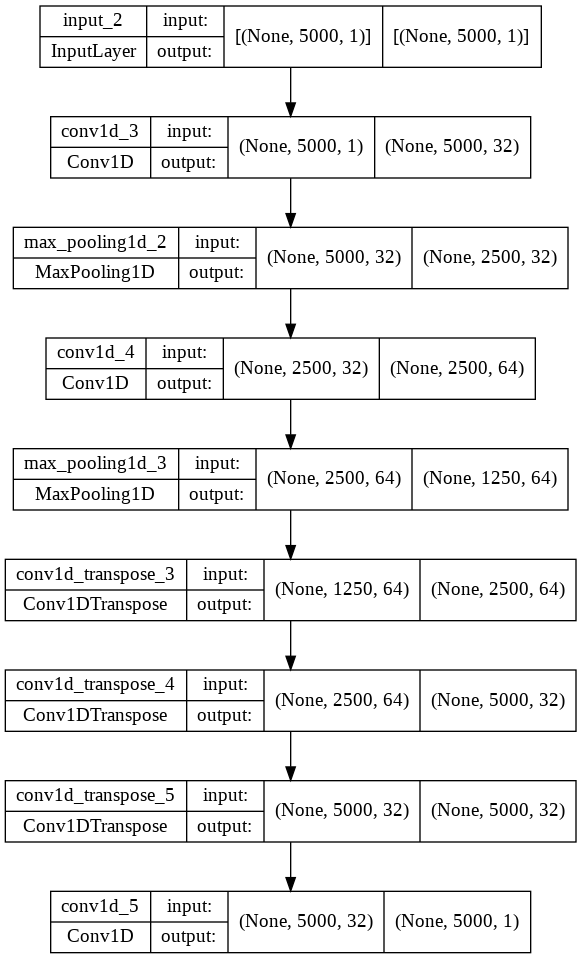

In [73]:
keras.utils.plot_model(autoencoder, show_shapes=True)

## Predictions

In [74]:
def model_ready(x):
  x = np.array(x)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  return x

In [75]:
noisy_test_data = model_ready(noisy_test_data)
noisy_train_data = model_ready(noisy_train_data)
test_data = model_ready(test_data)
train_data = model_ready(train_data)

In [76]:
noisy_test_data.shape

(900, 5000, 1)

In [77]:
train_data.shape

(2100, 5000, 1)

In [78]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/30
17/17 [==============================] - 3s 138ms/step - loss: 0.0019 - val_loss: 8.0762e-04
Epoch 2/30
17/17 [==============================] - 2s 97ms/step - loss: 7.1130e-04 - val_loss: 5.6163e-04
Epoch 3/30
17/17 [==============================] - 2s 97ms/step - loss: 4.8917e-04 - val_loss: 4.3524e-04
Epoch 4/30
17/17 [==============================] - 2s 97ms/step - loss: 3.9817e-04 - val_loss: 3.7015e-04
Epoch 5/30
17/17 [==============================] - 2s 97ms/step - loss: 3.5878e-04 - val_loss: 3.4167e-04
Epoch 6/30
17/17 [==============================] - 2s 97ms/step - loss: 3.3387e-04 - val_loss: 3.1702e-04
Epoch 7/30
17/17 [==============================] - 2s 97ms/step - loss: 3.1148e-04 - val_loss: 2.9384e-04
Epoch 8/30
17/17 [==============================] - 2s 98ms/step - loss: 2.8975e-04 - val_loss: 2.7182e-04
Epoch 9/30
17/17 [==============================] - 2s 98ms/step - loss: 2.6821e-04 - val_loss: 2.4884e-04
Epoch 10/30
17/17 [=====================

Let's now predict on the noisy data and display the results of our autoencoder.

In [79]:
prediction = autoencoder.predict(noisy_test_data)

In [80]:
prediction

array([[[-0.01165094],
        [ 0.00402412],
        [ 0.00127461],
        ...,
        [ 0.00021655],
        [-0.0036516 ],
        [ 0.02395623]],

       [[-0.01344564],
        [ 0.00231607],
        [-0.00136767],
        ...,
        [-0.00015085],
        [-0.00233741],
        [ 0.02540423]],

       [[-0.01239545],
        [ 0.00376022],
        [ 0.00088584],
        ...,
        [ 0.00294723],
        [-0.00035754],
        [ 0.02538818]],

       ...,

       [[-0.01237291],
        [ 0.00319922],
        [ 0.00058558],
        ...,
        [ 0.00112982],
        [-0.00035562],
        [ 0.02660099]],

       [[-0.01194511],
        [ 0.00379715],
        [ 0.00179245],
        ...,
        [-0.00129428],
        [-0.00492044],
        [ 0.02391222]],

       [[-0.01225068],
        [ 0.00426366],
        [ 0.00267562],
        ...,
        [ 0.00192036],
        [-0.00057553],
        [ 0.02593624]]], dtype=float32)

In [81]:
sf.write('noisy_test1.wav', noisy_test_data[0], 16000)
sf.write('pred_test1.wav', prediction[0], 16000)
sf.write('noisy_test2.wav', noisy_test_data[20], 16000)
sf.write('pred_test2.wav', prediction[20], 16000)

In [82]:
IPython.display.Audio('noisy_test2.wav')

In [83]:
IPython.display.Audio('pred_test2.wav')

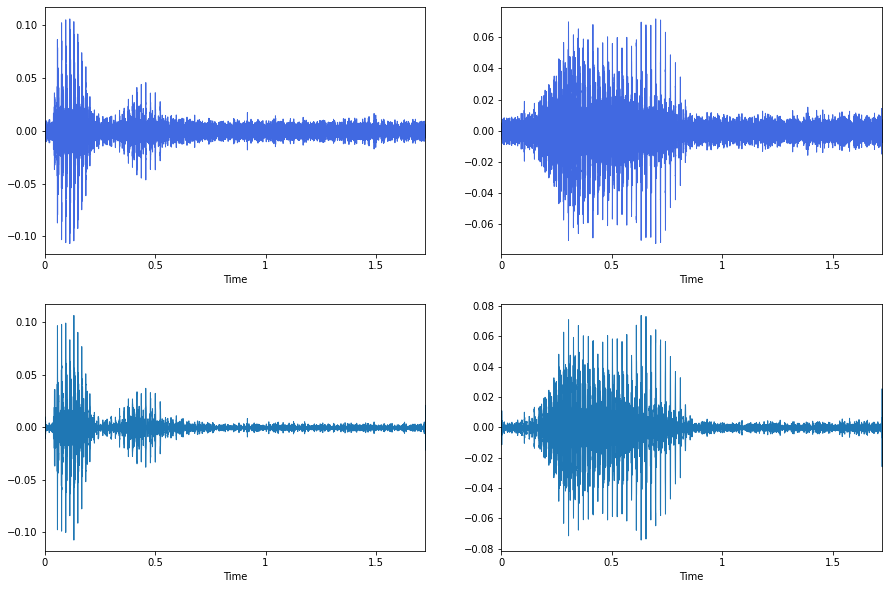

In [84]:
plt.figure(figsize=(15,10))
array = ["noisy_test1.wav", "noisy_test2.wav", "pred_test1.wav", "pred_test2.wav"]
for i in range(2):
    plt.subplot(2, 2, i + 1)
    j = librosa.load(array[i])
    librosa.display.waveplot(j[0], sr=16000, color = 'royalblue')
  
for i in range(2,4):
    plt.subplot(2, 2, i + 1)
    j = librosa.load(array[i])
    librosa.display.waveplot(j[0], sr=16000)

In [86]:
sample_test = model_ready(sample_test)
preidiction = autoencoder.predict(sample_test)

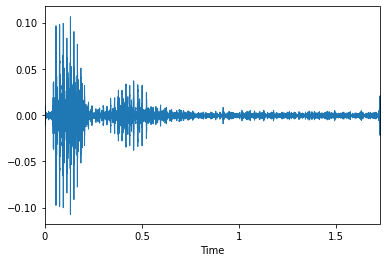

In [87]:
sf.write('pred_test3.wav', prediction[0], 16000)
j = librosa.load('pred_test3.wav')
librosa.display.waveplot(j[0], sr=16000)

In [88]:
IPython.display.Audio('pred_test3.wav')

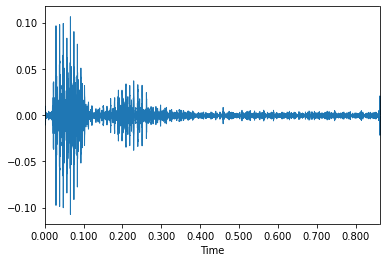

In [94]:
j = librosa.load('/content/pred_test3.wav')
librosa.display.waveplot(j[0], sr=16000)

In [29]:
autoencoder.save('/content/autoencoder_model.h5')

In [30]:
from keras.models import load_model
model = load_model('/content/autoencoder_model.h5')

In [8]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149860 sha256=48937dae6efa1eb9dad26ba5926ebeee22b70faa8d723dca7971a97c78a912a8
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [1]:
!pip3 install deepspeech==0.6.0
!curl -LO https://github.com/mozilla/DeepSpeech/releases/download/v0.6.0/deepspeech-0.6.0-models.tar.gz
!tar -xvzf deepspeech-0.6.0-models.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.0 MB/s 


In [4]:
import deepspeech

In [5]:
model_file_path = 'deepspeech-0.6.0-models/output_graph.pbmm'

In [6]:
beam_width = 500
model = deepspeech.Model(model_file_path, beam_width)
lm_file_path = 'deepspeech-0.6.0-models/lm.binary'
trie_file_path = 'deepspeech-0.6.0-models/trie'
lm_alpha = 0.75
lm_beta = 1.85

In [7]:
model.enableDecoderWithLM(lm_file_path, trie_file_path, lm_alpha, lm_beta)

0

In [ ]:
import wave
filename = ['/content/adversial_1.wav','content/normal_1.wav]
pred = []
for x in filename:
    w = wave.open(x, 'r')
    frames = w.getnframes()
    buffer = w.readframes(frames)
    print(buffer)
    import numpy as np
    data16 = np.frombuffer(buffer, dtype=np.int256)
    text = model.stt(data16)
    pred.append(text)

In [29]:
normal = pred[1]

In [31]:
adver = pred[0]

In [52]:
from jiwer import wer

wer(normal,adver)

0.875

In [55]:
rate = w.getframerate()
print(rate)

16000


In [56]:
!pip install speechbrain

In [ ]:
%%capture
import speechbrain 
# here we download the material needed for this tutorial: images and an example based on mini-librispeech
!wget https://www.dropbox.com/s/b61lo6gkpuplanq/MiniLibriSpeechTutorial.tar.gz?dl=0
!tar -xvzf MiniLibriSpeechTutorial.tar.gz?dl=0
# downloading mini_librispeech dev data
!wget https://www.openslr.org/resources/31/dev-clean-2.tar.gz
!tar -xvzf dev-clean-2.tar.gz

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/asr-crdnn-rnnlm-librispeech")
asr_model.transcribe_file("/content/adversial_1.wav")